In [1]:
import pandas as pd
import random
import numpy as np
import sklearn as sk
from scipy import stats
import statistics
import cvxpy as cvx
import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
xgboost.__version__
from scipy.linalg import svd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_name = './compas-scores-two-years.csv'
full_data = pd.read_csv(file_name)
full_data.race.value_counts()

print(full_data.shape)

# remove groups with few instances 
full_data = full_data.query("race != 'Asian'").query("race != 'Native American'")

# group by felony or misdemenor charge
full_data.groupby(['c_charge_degree','is_recid'])['id'].count().reset_index()

# turn charge degree to numbers 
full_data['c_charge_degree'] = pd.Categorical(full_data['c_charge_degree'])
# change numbers into dummies (1 for present 0 for absent)
dummies = pd.get_dummies(full_data['c_charge_degree'], prefix='charge')
full_data = pd.concat([full_data, dummies], axis=1)

# remove bad data
full_data = full_data.query("days_b_screening_arrest <= 30") \
        .query("days_b_screening_arrest >= -30")\
        .query("is_recid != -1")\
        .query("c_charge_degree != 'O'") \
        .query("score_text != 'N/A'" )

print(full_data.shape)

# randomize race for later use
full_data['race_random'] = np.random.permutation(full_data['race'])

# check how many random to the same thing
np.sum(full_data['race']==full_data['race_random'])

# check counts of recidivism by race
full_data.groupby(['race','is_recid'])['id'].count().reset_index()

# keep relevant columns 
columns_kept = ['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'priors_count', 'c_charge_degree', \
                'is_recid', 'decile_score', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'race_random', \
                'charge_F', 'charge_M', 'score_text', 'id']
full_data = full_data.loc[:, columns_kept]

full_data.set_index('id')

full_data.head()

(7214, 53)
(6130, 55)


,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,c_jail_in,c_jail_out,race_random,charge_F,charge_M,score_text,id
0,Male,69,Greater than 45,Other,0,0,F,0,1,0,2013-08-13 06:03:42,2013-08-14 05:41:20,Caucasian,1,0,Low,1
1,Male,34,25 - 45,African-American,0,0,F,1,3,1,2013-01-26 03:45:27,2013-02-05 05:36:53,Caucasian,1,0,Low,3
2,Male,24,Less than 25,African-American,0,4,F,1,4,1,2013-04-13 04:58:34,2013-04-14 07:02:04,Caucasian,1,0,Low,4
5,Male,44,25 - 45,Other,0,0,M,0,1,0,2013-11-30 04:50:18,2013-12-01 12:28:56,Caucasian,0,1,Low,7
6,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,2014-02-18 05:08:24,2014-02-24 12:18:30,African-American,1,0,Medium,8


In [3]:
learning_data = full_data.copy(deep=True)
features_to_transform = ['age_cat', 'sex', 'race', 'c_charge_degree']

for feature in features_to_transform:
    dummies = pd.get_dummies(learning_data[feature], prefix=feature)
    learning_data = pd.concat([learning_data, dummies], axis = 1)
learning_data.head()

learning_data.columns = learning_data.columns.str.replace('-', '_')

learning_data['score_factor'] = np.where(learning_data['score_text'] == 'Low', 'Low', 'MediumHigh')
dummies = pd.get_dummies(learning_data['score_factor'])
learning_data = pd.concat([learning_data, dummies] , axis = 1)
learning_data.head()

,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,...,sex_Male,race_African_American,race_Caucasian,race_Hispanic,race_Other,c_charge_degree_F,c_charge_degree_M,score_factor,Low,MediumHigh
0,Male,69,Greater than 45,Other,0,0,F,0,1,0,...,1,0,0,0,1,1,0,Low,1,0
1,Male,34,25 - 45,African-American,0,0,F,1,3,1,...,1,1,0,0,0,1,0,Low,1,0
2,Male,24,Less than 25,African-American,0,4,F,1,4,1,...,1,1,0,0,0,1,0,Low,1,0
5,Male,44,25 - 45,Other,0,0,M,0,1,0,...,1,0,0,0,1,0,1,Low,1,0
6,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,...,1,0,1,0,0,1,0,MediumHigh,0,1


In [4]:
X_Labels = ['sex_Male', 'sex_Female', 'age', 'race_African_American', 'race_Caucasian', 'priors_count',\
            'race_Hispanic', 'race_Other', 'juv_fel_count', 'c_charge_degree_F', 'c_charge_degree_M']
Y_Labels = ['Low']


X =  learning_data.loc[:, X_Labels]
Y =  learning_data.loc[:, Y_Labels]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =  0.2, random_state =  4)

# find and later remove linearly correlated pairs (not for xgboost but for LOCO later)
corr_thresh = .7
for column_a in X.columns:
    for column_b in X.columns:
        if column_a is not column_b:
            if X[column_a].corr(X[column_b]) > corr_thresh:
                print(column_a + " " + column_b)
    

xgb_full = xgboost.DMatrix(X, label=Y)
xgb_train =  xgboost.DMatrix(X_train, label = Y_train)
xgb_test = xgboost.DMatrix(X_test, label = Y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "tree_method": 'gpu_hist',
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
learning_data['pred'] = model.predict(xgb_full)


[0]	test-auc:0.81849
[1000]	test-auc:0.84334
[2000]	test-auc:0.84634
[3000]	test-auc:0.84599
[4000]	test-auc:0.84558
[5000]	test-auc:0.84475
[6000]	test-auc:0.84375
[7000]	test-auc:0.84289
[8000]	test-auc:0.84229
[9000]	test-auc:0.84161
[9999]	test-auc:0.84089


In [5]:
plt.hist(learning_data['pred'], bins = 20)
plt.show()

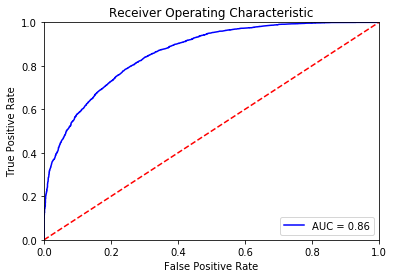

Optimal Threshold obtained using difference of TPR and FPR 0.5727081


In [6]:
%matplotlib inline
fpr, tpr , thresholds = roc_curve(learning_data['Low'], learning_data['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
learning_data['y_pred'] = np.where(learning_data['pred'] > optimal_threshold, 1, 0)

0.3792822185970636


## Find Burden

In [21]:

class CounterFactFactory:
    # do we need to mutate catagorical and continous data seperately? 
    # we probably need to ask for some bounds on each feature

    # bounds is a dict with form {<feature_name>: (<"catagorical"/"continous">, <number catagories/continous scale>)}
    # continous scale is max value for generating the initial population continous features
    # -(continous scale) is min value for generating the initial population
    def __init__(self, indiv, model_pred_func, bounds, fit_func, 
               selection_rate=.5, prob_mut=.2, prob_cross=.5, init_pop_size=1000,
               round_func=np.around, generations=200,
               **kwargs):
        self.model_pred_func = model_pred_func  # f(x)
        self.indiv = indiv                      # x
        self.c_fact_list = pd.DataFrame()       # subset of I
        self.feature_bounds = bounds            # may be used for mutation
        self.fitness = fit_func                 # d(x, c)
        self.pop_size = init_pop_size
        self.round_func = round_func
        self.p_s = selection_rate
        self.p_m = prob_mut
        self.p_c = prob_cross
        self.indiv_class = self.round_func(self.model_pred_func(xgboost.DMatrix(self.indiv)))
        self.indiv_class = self.indiv_class[0]
        self.gen = generations
        
        self.catL = [] 
        self.conL = []
        self.feature_names =  []
        
        for feature_name in self.feature_bounds:
            bounds = self.feature_bounds[feature_name]
            self.feature_names.append(feature_name)
            if bounds[0].startswith("cat"):
                self.catL.append(feature_name)
            elif bounds[0].startswith("cont"):
                self.conL.append(feature_name)
            else:
                print("error in bounds dictionary")
                print("expected catagorical or continous and got neither")
                raise ValueError()



    # step 7
    def genRandomCFactuals(self):
        
        temp = None
        if not self.c_fact_list.empty:
            temp = self.c_fact_list.columns
            
        # keep generating counter factuals until our population is up to size
        while self.c_fact_list.shape[0] < self.pop_size:
            # generate new individuals
            new_indivs = pd.DataFrame()
            for feature_name in self.feature_names:
                bounds = self.feature_bounds[feature_name]
                if bounds[0].startswith("cat"):
                    # catagorical random
                    new_indivs[feature_name] = np.random.randint(0, bounds[1], size=self.pop_size-self.c_fact_list.shape[0])
                elif bounds[0].startswith("cont"):
                    # continous random
                    new_indivs[feature_name] = np.random.rand(self.pop_size-self.c_fact_list.shape[0], 1) * (bounds[1])
                else:
                    print("error in bounds dictionary")
                    print("expected catagorical or continous and got neither")
            # calculate new predictions and filter
            new_indivs['prediction'] = new_indivs.apply(lambda row : 
                                                      self.round_func(self.model_pred_func(xgboost.DMatrix(pd.DataFrame(row).T)))[0],
                                                      axis = 1)
            new_indivs = new_indivs[new_indivs.prediction != self.indiv_class]

            # add the survivors to the dataframe
            if temp is None:
                temp = new_indivs.columns
                
            self.c_fact_list = pd.concat([self.c_fact_list, new_indivs], axis=0)
            self.c_fact_list = self.c_fact_list[temp]
            
    # step 8
    def selection(self):
        if self.c_fact_list is pd.DataFrame.empty:
            print("attempted to select on an empty population")
            print("try calling genRandomCFactuals first?")
            print("if this appears from a call of getCFactuals then its a bug. please report it")
            return

        # sort by fitness and then keep the top half
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis=1)
        self.c_fact_list = (self.c_fact_list.loc[self.c_fact_list.fitness.sort_values(ascending=False).index
                                                 ])[:int(self.c_fact_list.shape[0]*self.p_s)]

    # step 9
    def mutation(self):
        # get individuals to mutate
        to_mut_indivs = self.c_fact_list.sample(frac=self.p_m, axis=0)

        # mutate the individuals
        for index, individual in to_mut_indivs.iterrows():
          # do the mutation in place
          individual[0] = 0

        # set the counter factuals to their mutated version
        self.c_fact_list.loc[to_mut_indivs.index] = to_mut_indivs

        # recalculate the predictions
        self.c_fact_list.drop('prediction', inplace=True, axis=1)
        self.c_fact_list.drop('fitness', inplace=True, axis=1)
        self.c_fact_list['prediction'] = self.c_fact_list.apply(lambda row : 
                                                self.round_func(self.model_pred_func(xgboost.DMatrix(pd.DataFrame(row).T)))[0],
                                                axis = 1)
        
        # recalculate the fitnesses for use later
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis = 1)

    # step 10
    def crossover(self):
        # make sure to recalculate the fitnesses, and predictions
        # make sure to filter out
        # idea: 
        #1. sort by fitness, and keep top p_c portion. 
        #2. cross over between c_0 & c_1, c_2 & c_3, and so on
        #3. to cross over, swap each feature value with 50% probability
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis = 1)
        self.c_fact_list = (self.c_fact_list.loc[self.c_fact_list.fitness.sort_values(ascending=False).index])
        self.c_fact_list.drop('prediction', inplace=True, axis=1)
        self.c_fact_list.drop('fitness', inplace=True, axis=1)
        
        count = self.c_fact_list.shape[0] * self.p_c
        i = 0
        while i < count:
            for feature_name in self.feature_bounds:
                if(np.random.random_sample() > 0.5):
                    old_val = self.c_fact_list.loc[i, feature_name]
                    self.c_fact_list.loc[i, feature_name] = self.c_fact_list.loc[i+1, feature_name]
                    self.c_fact_list.loc[i, feature_name] = old_val
            i = i + 2
        pass
    
        self.c_fact_list['prediction'] = self.c_fact_list.apply(lambda row : 
                                        self.round_func(self.model_pred_func(xgboost.DMatrix(pd.DataFrame(row).T)))[0],
                                        axis = 1)

        # recalculate the fitnesses for use later
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis = 1)


    # step 11
    def filterCFacts(self):
        # filter the population of counter factuals (self.c_fact_list) to remove all
        # individuals that have the same prediction class (self.indiv_class) as the original 
        # individual (self.indiv)
        self.c_fact_list = self.c_fact_list[self.c_fact_list.prediction != self.indiv_class]
        pass

    # step 12
    def getCFactuals(self):

        for generation in range(self.gen):
            self.genRandomCFactuals()
            self.c_fact_list.reset_index(drop=True, inplace=True)
            
            self.selection()
            self.c_fact_list.reset_index(drop=True, inplace=True)
            
            self.mutation()
            self.c_fact_list.reset_index(drop=True, inplace=True)

            self.crossover()
            self.c_fact_list.reset_index(drop=True, inplace=True)

            self.filterCFacts()
            self.c_fact_list.reset_index(drop=True, inplace=True)
            
            if(generation == self.gen-1):
                print("Generation", generation, "with max fitness", self.c_fact_list.fitness.max())
            
        return self.c_fact_list.loc[0, :]


In [16]:
def d(indiv, other, cat, con):
    
    agg = pd.DataFrame(indiv)
    agg.loc[1] = other
    agg.reset_index(drop=True, inplace=True)
    
    ncat = len(cat)
    ncon = len(con)
    
    xcat = agg.loc[:, cat]
    xcon = agg.loc[:, con]
        
    # MAD normalized L1 Norm
    normedl1norm = 0
    for feature in con:
        mad = burden_data.loc[:, feature].mad()
        normedl1norm += abs(xcon.loc[0, feature] - xcon.loc[1, feature]) / mad
    
    # simpMat
    # both pos
    xcat = xcat.astype('int32')
    PosMat = xcat.loc[0] & xcat.loc[1] 
    NegMat = (1 - xcat.loc[0]) & (1 - xcat.loc[1])
    total = xcat.shape[1]
    dist = (PosMat.sum() + NegMat.sum())/total
    
    n = ncat + ncon
    return ncon*normedl1norm/n + ncat*dist/n

In [24]:

b = {
    'sex_Male':   ("catagorical", 2),
    'sex_Female': ("catagorical", 2),
    'age':        ("continous", 100),
    'race_African_American': ("catagorical", 2),
    'race_Caucasian': ("catagorical", 2),
    'priors_count':   ("continous", 100),
    'race_Hispanic':  ("catagorical", 2),
    'race_Other':     ("catagorical", 2),
    'juv_fel_count':  ("continous", 100),
    'c_charge_degree_F': ("catagorical", 2),
    'c_charge_degree_M': ("catagorical", 2)
}

cdf = pd.DataFrame(columns=['fitness']+X_Labels)
burden_data = learning_data.loc[:, X_Labels]

def inv_dist(ind, otr, cat, con):
    return 1 / d(ind, otr, cat, con)

for i in range(int(learning_data.shape[0])):
    
    burden_indiv = pd.DataFrame(burden_data.iloc[i]).T

    c_fact = CounterFactFactory(indiv=burden_indiv, model_pred_func=model.predict, bounds=b, 
                            fit_func=inv_dist, init_pop_size=100, generations=25)

    print("working on indiv", str(i))
    final_c_fact = c_fact.getCFactuals()
    cdf = cdf.append(final_c_fact)
    
cdf.head()

working on indiv 0
Generation 24 with max fitness 0.29621284290286304
working on indiv 1
Generation 24 with max fitness 1.375
working on indiv 2
Generation 24 with max fitness 0.48191398361587906
working on indiv 3
Generation 24 with max fitness 0.28044431579805856
working on indiv 4
Generation 24 with max fitness 0.8240128053065713
working on indiv 5
Generation 24 with max fitness 0.6165844512415105
working on indiv 6
Generation 24 with max fitness 0.2994752571436218
working on indiv 7
Generation 24 with max fitness 0.25368628712871366
working on indiv 8
Generation 24 with max fitness 0.3603016489296355
working on indiv 9
Generation 24 with max fitness 0.3666872758868499
working on indiv 10
Generation 24 with max fitness 0.2640176579925621
working on indiv 11
Generation 24 with max fitness 0.25317972166817304
working on indiv 12
Generation 24 with max fitness 0.6231895455586014
working on indiv 13
Generation 24 with max fitness 0.22817799351230636
working on indiv 14
Generation 24 wit

Generation 24 with max fitness 0.747355592979128
working on indiv 118
Generation 24 with max fitness 0.4308024082583566
working on indiv 119
Generation 24 with max fitness 0.262299171858458
working on indiv 120
Generation 24 with max fitness 0.587998398749359
working on indiv 121
Generation 24 with max fitness 0.33827983136486683
working on indiv 122
Generation 24 with max fitness 0.5602142368252332
working on indiv 123
Generation 24 with max fitness 0.5951064515900035
working on indiv 124
Generation 24 with max fitness 0.9113671268204794
working on indiv 125
Generation 24 with max fitness 0.3264591746606128
working on indiv 126
Generation 24 with max fitness 0.6525643288588312
working on indiv 127
Generation 24 with max fitness 0.6091649366158857
working on indiv 128
Generation 24 with max fitness 0.5689347602302275
working on indiv 129
Generation 24 with max fitness 0.3298700449981116
working on indiv 130
Generation 24 with max fitness 0.48192495066327007
working on indiv 131
Generat

Generation 24 with max fitness 0.7598686529141316
working on indiv 233
Generation 24 with max fitness 0.5976616333361959
working on indiv 234
Generation 24 with max fitness 0.48094510470336843
working on indiv 235
Generation 24 with max fitness 0.5725266127507068
working on indiv 236
Generation 24 with max fitness 0.4855668068611506
working on indiv 237
Generation 24 with max fitness 0.5735799766412997
working on indiv 238
Generation 24 with max fitness 0.3343901465193821
working on indiv 239
Generation 24 with max fitness 0.24751236426295334
working on indiv 240
Generation 24 with max fitness 0.5035600531092239
working on indiv 241
Generation 24 with max fitness 0.3459961376620241
working on indiv 242
Generation 24 with max fitness 0.5315649685583387
working on indiv 243
Generation 24 with max fitness 0.2861999056361057
working on indiv 244
Generation 24 with max fitness 0.736384681113729
working on indiv 245
Generation 24 with max fitness 0.38616459614239373
working on indiv 246
Gene

Generation 24 with max fitness 0.5038108631792969
working on indiv 349
Generation 24 with max fitness 0.6101759410645148
working on indiv 350
Generation 24 with max fitness 0.29757788453003253
working on indiv 351
Generation 24 with max fitness 0.8487620932735538
working on indiv 352
Generation 24 with max fitness 0.31656039370528094
working on indiv 353
Generation 24 with max fitness 0.507052073099293
working on indiv 354
Generation 24 with max fitness 0.3112611593837378
working on indiv 355
Generation 24 with max fitness 0.5145415278565691
working on indiv 356
Generation 24 with max fitness 0.39943587498287425
working on indiv 357
Generation 24 with max fitness 0.5152800810948525
working on indiv 358
Generation 24 with max fitness 0.5193437946267097
working on indiv 359
Generation 24 with max fitness 0.2437330016374049
working on indiv 360
Generation 24 with max fitness 0.36062625462495557
working on indiv 361
Generation 24 with max fitness 0.64924644222906
working on indiv 362
Gener

Generation 24 with max fitness 0.8346639218693308
working on indiv 464
Generation 24 with max fitness 0.47728128545297716
working on indiv 465
Generation 24 with max fitness 0.6376589441066619
working on indiv 466
Generation 24 with max fitness 0.4975564301107928
working on indiv 467
Generation 24 with max fitness 0.5629975597721082
working on indiv 468
Generation 24 with max fitness 0.6574445386712058
working on indiv 469
Generation 24 with max fitness 0.33137571544280325
working on indiv 470
Generation 24 with max fitness 0.4462204219621641
working on indiv 471
Generation 24 with max fitness 0.29181686580886523
working on indiv 472
Generation 24 with max fitness 0.4507914495192877
working on indiv 473
Generation 24 with max fitness 0.38038355759304315
working on indiv 474
Generation 24 with max fitness 0.5836803495489404
working on indiv 475
Generation 24 with max fitness 1.051273629682236
working on indiv 476
Generation 24 with max fitness 0.6165145922555142
working on indiv 477
Gen

Generation 24 with max fitness 0.34651532264075496
working on indiv 579
Generation 24 with max fitness 0.7603634560992643
working on indiv 580
Generation 24 with max fitness 0.3931792960857565
working on indiv 581
Generation 24 with max fitness 0.3260431780415927
working on indiv 582
Generation 24 with max fitness 0.2955244152131514
working on indiv 583
Generation 24 with max fitness 0.26287664832853597
working on indiv 584
Generation 24 with max fitness 0.5525320424126089
working on indiv 585
Generation 24 with max fitness 0.3349806788140906
working on indiv 586
Generation 24 with max fitness 0.26297378349858186
working on indiv 587
Generation 24 with max fitness 0.25491025097952597
working on indiv 588
Generation 24 with max fitness 0.30138842341031713
working on indiv 589
Generation 24 with max fitness 0.41010090382087877
working on indiv 590
Generation 24 with max fitness 0.839096033555196
working on indiv 591
Generation 24 with max fitness 0.8825539207706149
working on indiv 592
G

Generation 24 with max fitness 0.6838362224780857
working on indiv 694
Generation 24 with max fitness 0.4035307667946159
working on indiv 695
Generation 24 with max fitness 0.24072239135458237
working on indiv 696
Generation 24 with max fitness 1.771104180110551
working on indiv 697
Generation 24 with max fitness 0.4415690953201737
working on indiv 698
Generation 24 with max fitness 0.34677999435532975
working on indiv 699
Generation 24 with max fitness 0.43883882896611787
working on indiv 700
Generation 24 with max fitness 0.3551736467084882
working on indiv 701
Generation 24 with max fitness 0.3363634864033292
working on indiv 702
Generation 24 with max fitness 1.120591877874683
working on indiv 703
Generation 24 with max fitness 0.34094400673638026
working on indiv 704
Generation 24 with max fitness 0.4591577645079515
working on indiv 705
Generation 24 with max fitness 0.36980409139495335
working on indiv 706
Generation 24 with max fitness 0.781496532814064
working on indiv 707
Gene

Generation 24 with max fitness 0.45745988723393255
working on indiv 810
Generation 24 with max fitness 0.4101149650542186
working on indiv 811
Generation 24 with max fitness 0.5577341232024792
working on indiv 812
Generation 24 with max fitness 0.2733473685101268
working on indiv 813
Generation 24 with max fitness 0.24057615174381405
working on indiv 814
Generation 24 with max fitness 1.1259173793785908
working on indiv 815
Generation 24 with max fitness 0.5045330376928195
working on indiv 816
Generation 24 with max fitness 0.3659922102905877
working on indiv 817
Generation 24 with max fitness 0.5197325452135348
working on indiv 818
Generation 24 with max fitness 0.26230654514429447
working on indiv 819
Generation 24 with max fitness 0.7078808932608217
working on indiv 820
Generation 24 with max fitness 0.20945258983805612
working on indiv 821
Generation 24 with max fitness 0.43566383123653984
working on indiv 822
Generation 24 with max fitness 1.1107529343183526
working on indiv 823
G

Generation 24 with max fitness 0.6346340086265169
working on indiv 925
Generation 24 with max fitness 0.22244868774395188
working on indiv 926
Generation 24 with max fitness 0.6111045556817779
working on indiv 927
Generation 24 with max fitness 0.4381467789834595
working on indiv 928
Generation 24 with max fitness 1.1669455507690085
working on indiv 929
Generation 24 with max fitness 0.461290232161885
working on indiv 930
Generation 24 with max fitness 0.33891292416213253
working on indiv 931
Generation 24 with max fitness 0.4722959464669317
working on indiv 932
Generation 24 with max fitness 0.30780885198083546
working on indiv 933
Generation 24 with max fitness 0.47745906620962014
working on indiv 934
Generation 24 with max fitness 0.3898605506920884
working on indiv 935
Generation 24 with max fitness 0.4183135037186709
working on indiv 936
Generation 24 with max fitness 0.5216157914234151
working on indiv 937
Generation 24 with max fitness 0.497740422153266
working on indiv 938
Gene

Generation 24 with max fitness 0.8651243073008977
working on indiv 1040
Generation 24 with max fitness 0.6063665245144082
working on indiv 1041
Generation 24 with max fitness 0.5797332721505458
working on indiv 1042
Generation 24 with max fitness 0.3199236209946711
working on indiv 1043
Generation 24 with max fitness 0.4758344653554534
working on indiv 1044
Generation 24 with max fitness 0.28817485763173917
working on indiv 1045
Generation 24 with max fitness 1.0752289542184197
working on indiv 1046
Generation 24 with max fitness 0.5772387821453924
working on indiv 1047
Generation 24 with max fitness 0.3934035068303038
working on indiv 1048
Generation 24 with max fitness 0.4423114485465314
working on indiv 1049
Generation 24 with max fitness 0.30026549696480326
working on indiv 1050
Generation 24 with max fitness 0.6347837834218762
working on indiv 1051
Generation 24 with max fitness 0.298244168968295
working on indiv 1052
Generation 24 with max fitness 0.4486035823849002
working on in

Generation 24 with max fitness 0.37496353789533415
working on indiv 1154
Generation 24 with max fitness 0.9350232653957496
working on indiv 1155
Generation 24 with max fitness 0.4383698184323742
working on indiv 1156
Generation 24 with max fitness 0.5988521314697378
working on indiv 1157
Generation 24 with max fitness 0.2854147968038808
working on indiv 1158
Generation 24 with max fitness 3.6505738442636915
working on indiv 1159
Generation 24 with max fitness 0.2144272085774823
working on indiv 1160
Generation 24 with max fitness 0.31695322207516435
working on indiv 1161
Generation 24 with max fitness 0.5157428089894155
working on indiv 1162
Generation 24 with max fitness 0.3094576349729543
working on indiv 1163
Generation 24 with max fitness 0.5290189226263291
working on indiv 1164
Generation 24 with max fitness 1.5301060412965577
working on indiv 1165
Generation 24 with max fitness 0.6415622336818282
working on indiv 1166
Generation 24 with max fitness 0.20498520350357982
working on 

Generation 24 with max fitness 0.6652345484914574
working on indiv 1268
Generation 24 with max fitness 0.20620410590956698
working on indiv 1269
Generation 24 with max fitness 0.273954918934331
working on indiv 1270
Generation 24 with max fitness 1.0894238306805157
working on indiv 1271
Generation 24 with max fitness 0.4026077686016704
working on indiv 1272
Generation 24 with max fitness 0.3933787045149573
working on indiv 1273
Generation 24 with max fitness 0.5615076437769797
working on indiv 1274
Generation 24 with max fitness 0.26667713272461085
working on indiv 1275
Generation 24 with max fitness 0.6160333133703331
working on indiv 1276
Generation 24 with max fitness 0.21660736586049298
working on indiv 1277
Generation 24 with max fitness 0.5415203612925344
working on indiv 1278
Generation 24 with max fitness 0.5994382843342814
working on indiv 1279
Generation 24 with max fitness 0.8805426171550748
working on indiv 1280
Generation 24 with max fitness 0.23365740244593897
working on 

Generation 24 with max fitness 0.36293291376229064
working on indiv 1382
Generation 24 with max fitness 0.35950524239344817
working on indiv 1383
Generation 24 with max fitness 0.7541886118584148
working on indiv 1384
Generation 24 with max fitness 0.3716670074109731
working on indiv 1385
Generation 24 with max fitness 0.6847835100110758
working on indiv 1386
Generation 24 with max fitness 0.6162525789840315
working on indiv 1387
Generation 24 with max fitness 0.2918858598196423
working on indiv 1388
Generation 24 with max fitness 0.5028008565307226
working on indiv 1389
Generation 24 with max fitness 0.540536735454336
working on indiv 1390
Generation 24 with max fitness 0.527861212233917
working on indiv 1391
Generation 24 with max fitness 0.5000459874801089
working on indiv 1392
Generation 24 with max fitness 0.4355661582492774
working on indiv 1393
Generation 24 with max fitness 0.4061156186213955
working on indiv 1394
Generation 24 with max fitness 0.37204875238627494
working on in

Generation 24 with max fitness 0.4919197482109487
working on indiv 1496
Generation 24 with max fitness 0.3114211533432803
working on indiv 1497
Generation 24 with max fitness 0.35741681723966967
working on indiv 1498
Generation 24 with max fitness 0.23860530951809966
working on indiv 1499
Generation 24 with max fitness 0.5095036253732756
working on indiv 1500
Generation 24 with max fitness 0.3449440719639798
working on indiv 1501
Generation 24 with max fitness 0.29693107938562346
working on indiv 1502
Generation 24 with max fitness 0.27999906219466936
working on indiv 1503
Generation 24 with max fitness 0.43165560942083986
working on indiv 1504
Generation 24 with max fitness 0.45769564216476066
working on indiv 1505
Generation 24 with max fitness 0.666377537735789
working on indiv 1506
Generation 24 with max fitness 0.36191401562207093
working on indiv 1507
Generation 24 with max fitness 0.4006682501034596
working on indiv 1508
Generation 24 with max fitness 0.498878285371701
working o

Generation 24 with max fitness 0.31073598440531164
working on indiv 1610
Generation 24 with max fitness 0.6140145008648299
working on indiv 1611
Generation 24 with max fitness 0.3480559875513003
working on indiv 1612
Generation 24 with max fitness 1.4601053698031696
working on indiv 1613
Generation 24 with max fitness 0.4953530642732642
working on indiv 1614
Generation 24 with max fitness 0.21641583940466227
working on indiv 1615
Generation 24 with max fitness 0.35840862732772777
working on indiv 1616
Generation 24 with max fitness 0.2411516652931092
working on indiv 1617
Generation 24 with max fitness 0.40512558267695337
working on indiv 1618
Generation 24 with max fitness 0.3918622375187821
working on indiv 1619
Generation 24 with max fitness 1.0437659559443486
working on indiv 1620
Generation 24 with max fitness 0.2158048744330262
working on indiv 1621
Generation 24 with max fitness 0.23338081443319628
working on indiv 1622
Generation 24 with max fitness 0.25485520792901534
working 

Generation 24 with max fitness 1.082038810131289
working on indiv 1724
Generation 24 with max fitness 0.36782409201113486
working on indiv 1725
Generation 24 with max fitness 0.357302153169174
working on indiv 1726
Generation 24 with max fitness 0.31496772826994485
working on indiv 1727
Generation 24 with max fitness 0.25648042899709556
working on indiv 1728
Generation 24 with max fitness 0.5358376712349087
working on indiv 1729
Generation 24 with max fitness 0.5928179822277286
working on indiv 1730
Generation 24 with max fitness 1.0697478054547462
working on indiv 1731
Generation 24 with max fitness 0.25761724582335666
working on indiv 1732
Generation 24 with max fitness 0.5151603229341615
working on indiv 1733
Generation 24 with max fitness 0.7483474553485567
working on indiv 1734
Generation 24 with max fitness 0.24526212004236717
working on indiv 1735
Generation 24 with max fitness 0.4676808100314167
working on indiv 1736
Generation 24 with max fitness 0.3207053097016377
working on 

Generation 24 with max fitness 0.32334495324648244
working on indiv 1838
Generation 24 with max fitness 2.228097087161434
working on indiv 1839
Generation 24 with max fitness 0.2628044792890527
working on indiv 1840
Generation 24 with max fitness 0.5372710797748306
working on indiv 1841
Generation 24 with max fitness 0.4464807176212064
working on indiv 1842
Generation 24 with max fitness 1.0733684239377477
working on indiv 1843
Generation 24 with max fitness 0.3389530813092242
working on indiv 1844
Generation 24 with max fitness 0.9195925027247389
working on indiv 1845
Generation 24 with max fitness 0.24041524399435144
working on indiv 1846
Generation 24 with max fitness 0.24673806524193237
working on indiv 1847
Generation 24 with max fitness 0.4708789885713055
working on indiv 1848
Generation 24 with max fitness 0.9338243943946183
working on indiv 1849
Generation 24 with max fitness 0.3982943018728109
working on indiv 1850
Generation 24 with max fitness 0.3035482628103096
working on i

Generation 24 with max fitness 0.3900673760528169
working on indiv 1952
Generation 24 with max fitness 0.4077239143207205
working on indiv 1953
Generation 24 with max fitness 0.5288918818184383
working on indiv 1954
Generation 24 with max fitness 0.5117716641318998
working on indiv 1955
Generation 24 with max fitness 0.34904324347434695
working on indiv 1956
Generation 24 with max fitness 0.21638830244288904
working on indiv 1957
Generation 24 with max fitness 0.5455687012215191
working on indiv 1958
Generation 24 with max fitness 0.2503473666909047
working on indiv 1959
Generation 24 with max fitness 0.39338367807920144
working on indiv 1960
Generation 24 with max fitness 0.425997513727409
working on indiv 1961
Generation 24 with max fitness 0.3356090119977115
working on indiv 1962
Generation 24 with max fitness 0.5172470010701733
working on indiv 1963
Generation 24 with max fitness 0.3157854401685642
working on indiv 1964
Generation 24 with max fitness 0.9564873201089552
working on i

Generation 24 with max fitness 0.9429790070431655
working on indiv 2066
Generation 24 with max fitness 0.22151804306804682
working on indiv 2067
Generation 24 with max fitness 0.25783535157045817
working on indiv 2068
Generation 24 with max fitness 0.382466141797075
working on indiv 2069
Generation 24 with max fitness 0.2074454282829204
working on indiv 2070
Generation 24 with max fitness 0.6788689646824294
working on indiv 2071
Generation 24 with max fitness 0.21191828340654853
working on indiv 2072
Generation 24 with max fitness 0.44026188480183287
working on indiv 2073
Generation 24 with max fitness 0.5651429686355038
working on indiv 2074
Generation 24 with max fitness 0.238198693585815
working on indiv 2075
Generation 24 with max fitness 0.762319449050674
working on indiv 2076
Generation 24 with max fitness 0.5642037737346186
working on indiv 2077
Generation 24 with max fitness 0.21381370115260676
working on indiv 2078
Generation 24 with max fitness 0.2413620356872836
working on i

Generation 24 with max fitness 0.659419250508175
working on indiv 2180
Generation 24 with max fitness 0.8309818020797173
working on indiv 2181
Generation 24 with max fitness 0.47714364200926623
working on indiv 2182
Generation 24 with max fitness 0.9267054606712146
working on indiv 2183
Generation 24 with max fitness 0.32410719899979
working on indiv 2184
Generation 24 with max fitness 0.8362910986909334
working on indiv 2185
Generation 24 with max fitness 0.8278363702920746
working on indiv 2186
Generation 24 with max fitness 0.21675174724720547
working on indiv 2187
Generation 24 with max fitness 0.29974451703600025
working on indiv 2188
Generation 24 with max fitness 0.19538213471369167
working on indiv 2189
Generation 24 with max fitness 0.8864863429325083
working on indiv 2190
Generation 24 with max fitness 0.5689095837077742
working on indiv 2191
Generation 24 with max fitness 0.6758463724161764
working on indiv 2192
Generation 24 with max fitness 0.31433438416307735
working on i

Generation 24 with max fitness 0.6063390099687519
working on indiv 2294
Generation 24 with max fitness 0.27436568908406544
working on indiv 2295
Generation 24 with max fitness 1.1433029367625618
working on indiv 2296
Generation 24 with max fitness 0.9791263201499752
working on indiv 2297
Generation 24 with max fitness 0.26466479537991533
working on indiv 2298
Generation 24 with max fitness 0.4998902050227544
working on indiv 2299
Generation 24 with max fitness 0.49945900992254033
working on indiv 2300
Generation 24 with max fitness 0.3497431610138157
working on indiv 2301
Generation 24 with max fitness 0.3148897762965704
working on indiv 2302
Generation 24 with max fitness 0.6482564741322139
working on indiv 2303
Generation 24 with max fitness 0.324760632635101
working on indiv 2304
Generation 24 with max fitness 0.7257086983860325
working on indiv 2305
Generation 24 with max fitness 0.41346045478722054
working on indiv 2306
Generation 24 with max fitness 0.2351394778455085
working on 

Generation 24 with max fitness 0.47982141079123575
working on indiv 2408
Generation 24 with max fitness 0.34609362952863476
working on indiv 2409
Generation 24 with max fitness 0.2761337421708732
working on indiv 2410
Generation 24 with max fitness 0.6689946362949122
working on indiv 2411
Generation 24 with max fitness 0.22649581230975332
working on indiv 2412
Generation 24 with max fitness 0.2364761972296236
working on indiv 2413
Generation 24 with max fitness 0.31774974217425705
working on indiv 2414
Generation 24 with max fitness 0.1656470465572483
working on indiv 2415
Generation 24 with max fitness 0.5057653651981259
working on indiv 2416
Generation 24 with max fitness 0.22872059184855642
working on indiv 2417
Generation 24 with max fitness 0.34874416575555434
working on indiv 2418
Generation 24 with max fitness 0.40683007618653944
working on indiv 2419
Generation 24 with max fitness 0.20587373390040414
working on indiv 2420
Generation 24 with max fitness 0.6446394336412635
workin

Generation 24 with max fitness 0.7053298759709944
working on indiv 2522
Generation 24 with max fitness 0.38403389419054323
working on indiv 2523
Generation 24 with max fitness 0.2949855430665042
working on indiv 2524
Generation 24 with max fitness 0.2617543402258393
working on indiv 2525
Generation 24 with max fitness 0.5091748990798852
working on indiv 2526
Generation 24 with max fitness 1.1475416159591516
working on indiv 2527
Generation 24 with max fitness 0.17790843194267292
working on indiv 2528
Generation 24 with max fitness 0.36001769877808054
working on indiv 2529
Generation 24 with max fitness 0.4087260559620697
working on indiv 2530
Generation 24 with max fitness 0.6374471423488197
working on indiv 2531
Generation 24 with max fitness 0.35973186803541224
working on indiv 2532
Generation 24 with max fitness 0.35786409982316636
working on indiv 2533
Generation 24 with max fitness 0.29094015144922675
working on indiv 2534
Generation 24 with max fitness 0.45798521587628055
working

Generation 24 with max fitness 0.4720719758338139
working on indiv 2636
Generation 24 with max fitness 0.4074461565167933
working on indiv 2637
Generation 24 with max fitness 0.4723577142544011
working on indiv 2638
Generation 24 with max fitness 0.2614236929154639
working on indiv 2639
Generation 24 with max fitness 0.2502927021548537
working on indiv 2640
Generation 24 with max fitness 0.6325318496511898
working on indiv 2641
Generation 24 with max fitness 0.4310761164786834
working on indiv 2642
Generation 24 with max fitness 0.5947961455897265
working on indiv 2643
Generation 24 with max fitness 0.32203653767481966
working on indiv 2644
Generation 24 with max fitness 0.3262281818072434
working on indiv 2645
Generation 24 with max fitness 0.37059195101986564
working on indiv 2646
Generation 24 with max fitness 0.3424701183779744
working on indiv 2647
Generation 24 with max fitness 0.43014850037766866
working on indiv 2648
Generation 24 with max fitness 0.28625090131464426
working on

Generation 24 with max fitness 0.4127775011672597
working on indiv 2750
Generation 24 with max fitness 0.3185208316460903
working on indiv 2751
Generation 24 with max fitness 0.9768243434247493
working on indiv 2752
Generation 24 with max fitness 0.33812452122766895
working on indiv 2753
Generation 24 with max fitness 0.5035459995081608
working on indiv 2754
Generation 24 with max fitness 0.22634072976511246
working on indiv 2755
Generation 24 with max fitness 0.5272205122799207
working on indiv 2756
Generation 24 with max fitness 0.46278424876529245
working on indiv 2757
Generation 24 with max fitness 0.2396602845588089
working on indiv 2758
Generation 24 with max fitness 0.5712476982159764
working on indiv 2759
Generation 24 with max fitness 0.3847852205826041
working on indiv 2760
Generation 24 with max fitness 0.6944845847332032
working on indiv 2761
Generation 24 with max fitness 0.6772087767467785
working on indiv 2762
Generation 24 with max fitness 0.31827494556436686
working on

Generation 24 with max fitness 0.2689820147814267
working on indiv 2864
Generation 24 with max fitness 0.37385686931917506
working on indiv 2865
Generation 24 with max fitness 1.0651515085458025
working on indiv 2866
Generation 24 with max fitness 0.3538342933608571
working on indiv 2867
Generation 24 with max fitness 1.1897366472481483
working on indiv 2868
Generation 24 with max fitness 0.533503340131798
working on indiv 2869
Generation 24 with max fitness 0.24527326408873054
working on indiv 2870
Generation 24 with max fitness 0.24337595621590247
working on indiv 2871
Generation 24 with max fitness 0.2794389823770054
working on indiv 2872
Generation 24 with max fitness 0.6869355879758892
working on indiv 2873
Generation 24 with max fitness 0.2702996571246492
working on indiv 2874
Generation 24 with max fitness 0.5491189747062218
working on indiv 2875
Generation 24 with max fitness 0.2958961192141679
working on indiv 2876
Generation 24 with max fitness 0.6085185563519178
working on i

Generation 24 with max fitness 0.7873226421879517
working on indiv 2978
Generation 24 with max fitness 0.6693251740611276
working on indiv 2979
Generation 24 with max fitness 0.5211109185007731
working on indiv 2980
Generation 24 with max fitness 0.7607269605242092
working on indiv 2981
Generation 24 with max fitness 0.9010253366375133
working on indiv 2982
Generation 24 with max fitness 0.28514114480643304
working on indiv 2983
Generation 24 with max fitness 0.6542456458012731
working on indiv 2984
Generation 24 with max fitness 0.22929436217897312
working on indiv 2985
Generation 24 with max fitness 0.5814007605223366
working on indiv 2986
Generation 24 with max fitness 0.9106250238434999
working on indiv 2987
Generation 24 with max fitness 1.3490195762572865
working on indiv 2988
Generation 24 with max fitness 0.5215122083585416
working on indiv 2989
Generation 24 with max fitness 0.25243089505870225
working on indiv 2990
Generation 24 with max fitness 0.4613175012060808
working on 

Generation 24 with max fitness 0.39260948047783334
working on indiv 3092
Generation 24 with max fitness 0.26443231846655246
working on indiv 3093
Generation 24 with max fitness 0.8402556312580772
working on indiv 3094
Generation 24 with max fitness 0.3012703551724469
working on indiv 3095
Generation 24 with max fitness 0.4066590353060124
working on indiv 3096
Generation 24 with max fitness 0.28061088850053956
working on indiv 3097
Generation 24 with max fitness 0.4042762472224581
working on indiv 3098
Generation 24 with max fitness 0.504790795341732
working on indiv 3099
Generation 24 with max fitness 0.8325123937966061
working on indiv 3100
Generation 24 with max fitness 0.5712748968114393
working on indiv 3101
Generation 24 with max fitness 0.6447480972624937
working on indiv 3102
Generation 24 with max fitness 0.42434761805307947
working on indiv 3103
Generation 24 with max fitness 0.4533412393243695
working on indiv 3104
Generation 24 with max fitness 0.30577291872449575
working on

Generation 24 with max fitness 0.35498734585281116
working on indiv 3206
Generation 24 with max fitness 0.34874553575133665
working on indiv 3207
Generation 24 with max fitness 0.2631036458796839
working on indiv 3208
Generation 24 with max fitness 0.744441636196048
working on indiv 3209
Generation 24 with max fitness 0.6404814331293749
working on indiv 3210
Generation 24 with max fitness 0.2939687013907099
working on indiv 3211
Generation 24 with max fitness 0.35179398026555464
working on indiv 3212
Generation 24 with max fitness 0.321871539254812
working on indiv 3213
Generation 24 with max fitness 0.3907683365035572
working on indiv 3214
Generation 24 with max fitness 0.37452168917823875
working on indiv 3215
Generation 24 with max fitness 0.5606975020694972
working on indiv 3216
Generation 24 with max fitness 0.3890971867065084
working on indiv 3217
Generation 24 with max fitness 0.2695680948184036
working on indiv 3218
Generation 24 with max fitness 0.31999118012253724
working on 

Generation 24 with max fitness 0.3537685602322896
working on indiv 3320
Generation 24 with max fitness 0.36119002319002586
working on indiv 3321
Generation 24 with max fitness 0.4325121697352896
working on indiv 3322
Generation 24 with max fitness 0.35161981096093464
working on indiv 3323
Generation 24 with max fitness 0.36531482095456463
working on indiv 3324
Generation 24 with max fitness 0.4266398469492546
working on indiv 3325
Generation 24 with max fitness 0.371719679377693
working on indiv 3326
Generation 24 with max fitness 0.2454778658675156
working on indiv 3327
Generation 24 with max fitness 0.39040459893947566
working on indiv 3328
Generation 24 with max fitness 0.3358140965218004
working on indiv 3329
Generation 24 with max fitness 0.27969969945653816
working on indiv 3330
Generation 24 with max fitness 0.9457953402067402
working on indiv 3331
Generation 24 with max fitness 0.41139524278728734
working on indiv 3332
Generation 24 with max fitness 1.1281457764758418
working o

Generation 24 with max fitness 0.2745347713949577
working on indiv 3434
Generation 24 with max fitness 0.6909059554666094
working on indiv 3435
Generation 24 with max fitness 0.6937736587173295
working on indiv 3436
Generation 24 with max fitness 0.45057244449080225
working on indiv 3437
Generation 24 with max fitness 0.5694038885139432
working on indiv 3438
Generation 24 with max fitness 0.4362738466621714
working on indiv 3439
Generation 24 with max fitness 0.6395671179027806
working on indiv 3440
Generation 24 with max fitness 0.22803492958092395
working on indiv 3441
Generation 24 with max fitness 0.6855312879341721
working on indiv 3442
Generation 24 with max fitness 1.259497347534217
working on indiv 3443
Generation 24 with max fitness 0.4860315990094392
working on indiv 3444
Generation 24 with max fitness 0.9348723167297328
working on indiv 3445
Generation 24 with max fitness 0.7945726310247999
working on indiv 3446
Generation 24 with max fitness 0.2803629668886222
working on in

Generation 24 with max fitness 0.33296312248905635
working on indiv 3548
Generation 24 with max fitness 0.20897251040909406
working on indiv 3549
Generation 24 with max fitness 0.5184887217192492
working on indiv 3550
Generation 24 with max fitness 0.3082229256864809
working on indiv 3551
Generation 24 with max fitness 0.30491469536524
working on indiv 3552
Generation 24 with max fitness 0.8388129574908324
working on indiv 3553
Generation 24 with max fitness 0.6968817279562998
working on indiv 3554
Generation 24 with max fitness 0.8967722669000475
working on indiv 3555
Generation 24 with max fitness 0.4246597748997159
working on indiv 3556
Generation 24 with max fitness 0.6103791678510463
working on indiv 3557
Generation 24 with max fitness 0.26132572301007545
working on indiv 3558
Generation 24 with max fitness 0.3488088439315674
working on indiv 3559
Generation 24 with max fitness 0.39820968210749663
working on indiv 3560
Generation 24 with max fitness 0.37802032044831624
working on 

Generation 24 with max fitness 0.2793251196597066
working on indiv 3662
Generation 24 with max fitness 1.2299922157424623
working on indiv 3663
Generation 24 with max fitness 1.226426797676652
working on indiv 3664
Generation 24 with max fitness 0.4946893955166953
working on indiv 3665
Generation 24 with max fitness 0.566792822973168
working on indiv 3666
Generation 24 with max fitness 0.2518862565985467
working on indiv 3667
Generation 24 with max fitness 0.31467348648972765
working on indiv 3668
Generation 24 with max fitness 0.2550781871202145
working on indiv 3669
Generation 24 with max fitness 0.2772321554250794
working on indiv 3670
Generation 24 with max fitness 0.4858977019741083
working on indiv 3671
Generation 24 with max fitness 0.40963986204850134
working on indiv 3672
Generation 24 with max fitness 0.3636522308876548
working on indiv 3673
Generation 24 with max fitness 0.7817500559627175
working on indiv 3674
Generation 24 with max fitness 0.28967565667394507
working on in

Generation 24 with max fitness 0.7219624367103945
working on indiv 3776
Generation 24 with max fitness 0.27092531570773554
working on indiv 3777
Generation 24 with max fitness 0.24611292027759632
working on indiv 3778
Generation 24 with max fitness 1.2661901922949705
working on indiv 3779
Generation 24 with max fitness 0.44363950980109385
working on indiv 3780
Generation 24 with max fitness 0.2946482564567759
working on indiv 3781
Generation 24 with max fitness 0.2616702328292262
working on indiv 3782
Generation 24 with max fitness 0.42837901935433004
working on indiv 3783
Generation 24 with max fitness 0.2929171186673837
working on indiv 3784
Generation 24 with max fitness 0.733759402056595
working on indiv 3785
Generation 24 with max fitness 0.6452522674146312
working on indiv 3786
Generation 24 with max fitness 0.4617345260979692
working on indiv 3787
Generation 24 with max fitness 1.0449565020189628
working on indiv 3788
Generation 24 with max fitness 0.7631257322784107
working on 

Generation 24 with max fitness 0.43724817943325806
working on indiv 3890
Generation 24 with max fitness 0.5977333179852973
working on indiv 3891
Generation 24 with max fitness 0.32779298722972944
working on indiv 3892
Generation 24 with max fitness 0.3295744725597985
working on indiv 3893
Generation 24 with max fitness 0.25776693814305585
working on indiv 3894
Generation 24 with max fitness 0.5864721052773637
working on indiv 3895
Generation 24 with max fitness 0.39057955474193307
working on indiv 3896
Generation 24 with max fitness 0.6373117507553677
working on indiv 3897
Generation 24 with max fitness 0.263466601881776
working on indiv 3898
Generation 24 with max fitness 0.5333249607977196
working on indiv 3899
Generation 24 with max fitness 0.958521986398793
working on indiv 3900
Generation 24 with max fitness 0.9520866002421351
working on indiv 3901
Generation 24 with max fitness 0.29417143562878023
working on indiv 3902
Generation 24 with max fitness 0.6860918511856218
working on 

Generation 24 with max fitness 0.6514998252281022
working on indiv 4004
Generation 24 with max fitness 0.42203977641745904
working on indiv 4005
Generation 24 with max fitness 1.0797701376273727
working on indiv 4006
Generation 24 with max fitness 0.2439878603955695
working on indiv 4007
Generation 24 with max fitness 0.8982285539255308
working on indiv 4008
Generation 24 with max fitness 0.519451213258758
working on indiv 4009
Generation 24 with max fitness 0.47979490337217645
working on indiv 4010
Generation 24 with max fitness 0.6552758724616836
working on indiv 4011
Generation 24 with max fitness 0.626038420291647
working on indiv 4012
Generation 24 with max fitness 0.764796598181054
working on indiv 4013
Generation 24 with max fitness 0.5278100200263466
working on indiv 4014
Generation 24 with max fitness 0.32776664337189226
working on indiv 4015
Generation 24 with max fitness 0.5753528087328349
working on indiv 4016
Generation 24 with max fitness 0.7399757738237612
working on ind

Generation 24 with max fitness 0.4988162766143667
working on indiv 4118
Generation 24 with max fitness 0.4162551626405966
working on indiv 4119
Generation 24 with max fitness 0.444136038557697
working on indiv 4120
Generation 24 with max fitness 0.3697775349989851
working on indiv 4121
Generation 24 with max fitness 0.21962787436454437
working on indiv 4122
Generation 24 with max fitness 0.6642137803190952
working on indiv 4123
Generation 24 with max fitness 0.744539396201049
working on indiv 4124
Generation 24 with max fitness 0.46288658602331767
working on indiv 4125
Generation 24 with max fitness 0.32561640658482016
working on indiv 4126
Generation 24 with max fitness 0.7933416847324959
working on indiv 4127
Generation 24 with max fitness 0.2990391528907811
working on indiv 4128
Generation 24 with max fitness 0.5007249530942626
working on indiv 4129
Generation 24 with max fitness 1.0297859381075327
working on indiv 4130
Generation 24 with max fitness 0.2204083255089908
working on in

Generation 24 with max fitness 0.5512611593381496
working on indiv 4232
Generation 24 with max fitness 0.8062058900006315
working on indiv 4233
Generation 24 with max fitness 0.5422252494425042
working on indiv 4234
Generation 24 with max fitness 0.6453639661467314
working on indiv 4235
Generation 24 with max fitness 0.3978942571102085
working on indiv 4236
Generation 24 with max fitness 0.33651565958743496
working on indiv 4237
Generation 24 with max fitness 0.5249826638835071
working on indiv 4238
Generation 24 with max fitness 0.47295752887872555
working on indiv 4239
Generation 24 with max fitness 0.48219615350763584
working on indiv 4240
Generation 24 with max fitness 0.30138431940047744
working on indiv 4241
Generation 24 with max fitness 0.3034443358709387
working on indiv 4242
Generation 24 with max fitness 0.5454613001151283
working on indiv 4243
Generation 24 with max fitness 0.5460511451661118
working on indiv 4244
Generation 24 with max fitness 1.4183099726557047
working on

Generation 24 with max fitness 0.9089467772035734
working on indiv 4346
Generation 24 with max fitness 0.30507290450714275
working on indiv 4347
Generation 24 with max fitness 0.6597444054142642
working on indiv 4348
Generation 24 with max fitness 0.7942046672593276
working on indiv 4349
Generation 24 with max fitness 0.6015637764537712
working on indiv 4350
Generation 24 with max fitness 0.28666553664182576
working on indiv 4351
Generation 24 with max fitness 0.672355786683756
working on indiv 4352
Generation 24 with max fitness 0.40627548697205823
working on indiv 4353
Generation 24 with max fitness 0.6332846330810055
working on indiv 4354
Generation 24 with max fitness 0.6602475321922252
working on indiv 4355
Generation 24 with max fitness 0.4312163824744619
working on indiv 4356
Generation 24 with max fitness 0.2706827865751657
working on indiv 4357
Generation 24 with max fitness 0.3697921734871551
working on indiv 4358
Generation 24 with max fitness 0.5677372282124198
working on i

Generation 24 with max fitness 0.7186190065095548
working on indiv 4460
Generation 24 with max fitness 0.7963681634368391
working on indiv 4461
Generation 24 with max fitness 0.5488471920793446
working on indiv 4462
Generation 24 with max fitness 1.551298038381296
working on indiv 4463
Generation 24 with max fitness 0.5776461250152962
working on indiv 4464
Generation 24 with max fitness 0.376351789469732
working on indiv 4465
Generation 24 with max fitness 0.4978989807946634
working on indiv 4466
Generation 24 with max fitness 0.6705092356159232
working on indiv 4467
Generation 24 with max fitness 0.7243100175087829
working on indiv 4468
Generation 24 with max fitness 0.5560136003350783
working on indiv 4469
Generation 24 with max fitness 0.24659104896527992
working on indiv 4470
Generation 24 with max fitness 0.48910635101304883
working on indiv 4471
Generation 24 with max fitness 0.42203936176988527
working on indiv 4472
Generation 24 with max fitness 0.654598825640142
working on ind

Generation 24 with max fitness 0.39868656750120657
working on indiv 4574
Generation 24 with max fitness 0.27756078600165673
working on indiv 4575
Generation 24 with max fitness 1.1894476188148606
working on indiv 4576
Generation 24 with max fitness 0.4638458746000376
working on indiv 4577
Generation 24 with max fitness 0.6784198891131751
working on indiv 4578
Generation 24 with max fitness 0.5572419367390561
working on indiv 4579
Generation 24 with max fitness 0.43719126445844836
working on indiv 4580
Generation 24 with max fitness 0.5553765819145677
working on indiv 4581
Generation 24 with max fitness 0.3800929744556035
working on indiv 4582
Generation 24 with max fitness 0.20669335896549343
working on indiv 4583
Generation 24 with max fitness 0.767605594984127
working on indiv 4584
Generation 24 with max fitness 0.6492085787162798
working on indiv 4585
Generation 24 with max fitness 0.607048404660626
working on indiv 4586
Generation 24 with max fitness 0.33453796698702626
working on 

Generation 24 with max fitness 0.22262584447024206
working on indiv 4688
Generation 24 with max fitness 0.5415701564692006
working on indiv 4689
Generation 24 with max fitness 0.26291568756798833
working on indiv 4690
Generation 24 with max fitness 0.2724465333795357
working on indiv 4691
Generation 24 with max fitness 0.5436771408676758
working on indiv 4692
Generation 24 with max fitness 0.37689092369578003
working on indiv 4693
Generation 24 with max fitness 0.26818577961464124
working on indiv 4694
Generation 24 with max fitness 0.5795273940360305
working on indiv 4695
Generation 24 with max fitness 0.6529730813781365
working on indiv 4696
Generation 24 with max fitness 1.0771217129668977
working on indiv 4697
Generation 24 with max fitness 0.32457297792264955
working on indiv 4698
Generation 24 with max fitness 0.4423489610563457
working on indiv 4699
Generation 24 with max fitness 0.3161941400932283
working on indiv 4700
Generation 24 with max fitness 0.3839476153251147
working o

Generation 24 with max fitness 0.3240738349759234
working on indiv 4802
Generation 24 with max fitness 0.36546313191178964
working on indiv 4803
Generation 24 with max fitness 0.5768101944028708
working on indiv 4804
Generation 24 with max fitness 0.14507291947599477
working on indiv 4805
Generation 24 with max fitness 0.29313076991320586
working on indiv 4806
Generation 24 with max fitness 0.29093421976093226
working on indiv 4807
Generation 24 with max fitness 0.1973700035559782
working on indiv 4808
Generation 24 with max fitness 0.6127378338147804
working on indiv 4809
Generation 24 with max fitness 1.147995493670051
working on indiv 4810
Generation 24 with max fitness 0.33535818418784447
working on indiv 4811
Generation 24 with max fitness 0.52878449659206
working on indiv 4812
Generation 24 with max fitness 0.4232689871141831
working on indiv 4813
Generation 24 with max fitness 0.7309812440712167
working on indiv 4814
Generation 24 with max fitness 0.30366790690858203
working on 

Generation 24 with max fitness 0.7378627856169857
working on indiv 4916
Generation 24 with max fitness 0.724657738717057
working on indiv 4917
Generation 24 with max fitness 0.3468579984321263
working on indiv 4918
Generation 24 with max fitness 0.21400012920773856
working on indiv 4919
Generation 24 with max fitness 0.4458337847721015
working on indiv 4920
Generation 24 with max fitness 0.2751565423307489
working on indiv 4921
Generation 24 with max fitness 0.3167145719588689
working on indiv 4922
Generation 24 with max fitness 0.22267158856323976
working on indiv 4923
Generation 24 with max fitness 0.39993865197160267
working on indiv 4924
Generation 24 with max fitness 0.483930124959646
working on indiv 4925
Generation 24 with max fitness 0.5050084784980596
working on indiv 4926
Generation 24 with max fitness 0.6256408973351991
working on indiv 4927
Generation 24 with max fitness 0.46539799576465807
working on indiv 4928
Generation 24 with max fitness 0.7728866083323017
working on i

Generation 24 with max fitness 0.4599630624726443
working on indiv 5030
Generation 24 with max fitness 0.2974011905651056
working on indiv 5031
Generation 24 with max fitness 0.18968259572326593
working on indiv 5032
Generation 24 with max fitness 0.38182946647378024
working on indiv 5033
Generation 24 with max fitness 0.22439965826564795
working on indiv 5034
Generation 24 with max fitness 0.636377954580168
working on indiv 5035
Generation 24 with max fitness 0.3155074776677832
working on indiv 5036
Generation 24 with max fitness 0.20529192475820335
working on indiv 5037
Generation 24 with max fitness 0.34956449426123914
working on indiv 5038
Generation 24 with max fitness 0.5179887111735573
working on indiv 5039
Generation 24 with max fitness 0.5287430544746694
working on indiv 5040
Generation 24 with max fitness 0.41146115400961436
working on indiv 5041
Generation 24 with max fitness 0.2921426772705416
working on indiv 5042
Generation 24 with max fitness 0.6895256181191717
working o

Generation 24 with max fitness 0.573463576100285
working on indiv 5144
Generation 24 with max fitness 0.23249942373210783
working on indiv 5145
Generation 24 with max fitness 0.39922636507001236
working on indiv 5146
Generation 24 with max fitness 0.5242361091686809
working on indiv 5147
Generation 24 with max fitness 0.5120706290885702
working on indiv 5148
Generation 24 with max fitness 0.2424478443799907
working on indiv 5149
Generation 24 with max fitness 0.29578414136191533
working on indiv 5150
Generation 24 with max fitness 0.3184018219795291
working on indiv 5151
Generation 24 with max fitness 0.2503444285813694
working on indiv 5152
Generation 24 with max fitness 0.7382934087454021
working on indiv 5153
Generation 24 with max fitness 0.2705225328892382
working on indiv 5154
Generation 24 with max fitness 0.3293891836960728
working on indiv 5155
Generation 24 with max fitness 0.6371943955939633
working on indiv 5156
Generation 24 with max fitness 0.20385590395661674
working on 

Generation 24 with max fitness 0.4422965478361963
working on indiv 5258
Generation 24 with max fitness 0.33293357383697736
working on indiv 5259
Generation 24 with max fitness 0.711318788865593
working on indiv 5260
Generation 24 with max fitness 1.1435194846848455
working on indiv 5261
Generation 24 with max fitness 0.5052616884264859
working on indiv 5262
Generation 24 with max fitness 0.36743970113480534
working on indiv 5263
Generation 24 with max fitness 0.3604099713848999
working on indiv 5264
Generation 24 with max fitness 0.44022437026572436
working on indiv 5265
Generation 24 with max fitness 0.8162483205692527
working on indiv 5266
Generation 24 with max fitness 0.6089345159586644
working on indiv 5267
Generation 24 with max fitness 0.6824943949801443
working on indiv 5268
Generation 24 with max fitness 0.24884638202022782
working on indiv 5269
Generation 24 with max fitness 0.572861960618285
working on indiv 5270
Generation 24 with max fitness 0.5693972925389356
working on i

Generation 24 with max fitness 0.5418337570371815
working on indiv 5372
Generation 24 with max fitness 0.5520407894477329
working on indiv 5373
Generation 24 with max fitness 0.2602508358737244
working on indiv 5374
Generation 24 with max fitness 0.42973198668511037
working on indiv 5375
Generation 24 with max fitness 0.40398228638006317
working on indiv 5376
Generation 24 with max fitness 0.7458730753244981
working on indiv 5377
Generation 24 with max fitness 0.3111845873673774
working on indiv 5378
Generation 24 with max fitness 0.7301979675223731
working on indiv 5379
Generation 24 with max fitness 0.2577008127964938
working on indiv 5380
Generation 24 with max fitness 0.2946640270670001
working on indiv 5381
Generation 24 with max fitness 0.28482376559416406
working on indiv 5382
Generation 24 with max fitness 0.8566412973607822
working on indiv 5383
Generation 24 with max fitness 0.8644288192455309
working on indiv 5384
Generation 24 with max fitness 0.2619587649624007
working on 

Generation 24 with max fitness 0.40088365341370125
working on indiv 5486
Generation 24 with max fitness 0.6095021139590625
working on indiv 5487
Generation 24 with max fitness 0.9035976060309647
working on indiv 5488
Generation 24 with max fitness 0.411970756725817
working on indiv 5489
Generation 24 with max fitness 0.29799662217657785
working on indiv 5490
Generation 24 with max fitness 0.5719723368790807
working on indiv 5491
Generation 24 with max fitness 0.24314922990556265
working on indiv 5492
Generation 24 with max fitness 0.4236743864996947
working on indiv 5493
Generation 24 with max fitness 0.4554450046022718
working on indiv 5494
Generation 24 with max fitness 0.47799009308913076
working on indiv 5495
Generation 24 with max fitness 0.34267153752560153
working on indiv 5496
Generation 24 with max fitness 0.6714139670457359
working on indiv 5497
Generation 24 with max fitness 0.2351437854775399
working on indiv 5498
Generation 24 with max fitness 0.648965687403775
working on 

Generation 24 with max fitness 0.20237058351629145
working on indiv 5600
Generation 24 with max fitness 0.9403784057710568
working on indiv 5601
Generation 24 with max fitness 0.33163407221423674
working on indiv 5602
Generation 24 with max fitness 0.28591855474650574
working on indiv 5603
Generation 24 with max fitness 0.33743190493031155
working on indiv 5604
Generation 24 with max fitness 0.31788140959853595
working on indiv 5605
Generation 24 with max fitness 0.445282055441516
working on indiv 5606
Generation 24 with max fitness 0.3742828726322888
working on indiv 5607
Generation 24 with max fitness 0.24445259419236576
working on indiv 5608
Generation 24 with max fitness 0.5229801032732742
working on indiv 5609
Generation 24 with max fitness 0.25164221304685436
working on indiv 5610
Generation 24 with max fitness 0.44544230187402833
working on indiv 5611
Generation 24 with max fitness 0.3343848714654823
working on indiv 5612
Generation 24 with max fitness 0.2660147689243819
working

Generation 24 with max fitness 0.26171010024644603
working on indiv 5714
Generation 24 with max fitness 0.35031377845366857
working on indiv 5715
Generation 24 with max fitness 0.49284810611038654
working on indiv 5716
Generation 24 with max fitness 0.3221688264712507
working on indiv 5717
Generation 24 with max fitness 0.8574427283860128
working on indiv 5718
Generation 24 with max fitness 0.3405398659884861
working on indiv 5719
Generation 24 with max fitness 0.4317168924017986
working on indiv 5720
Generation 24 with max fitness 1.0809494914520852
working on indiv 5721
Generation 24 with max fitness 0.2845857649226838
working on indiv 5722
Generation 24 with max fitness 0.4176978101031293
working on indiv 5723
Generation 24 with max fitness 0.3055374554178807
working on indiv 5724
Generation 24 with max fitness 0.38640637893796476
working on indiv 5725
Generation 24 with max fitness 0.30023312663371804
working on indiv 5726
Generation 24 with max fitness 1.3630992958161625
working o

Generation 24 with max fitness 0.455919956297033
working on indiv 5828
Generation 24 with max fitness 0.34141090752216363
working on indiv 5829
Generation 24 with max fitness 1.0276491178943399
working on indiv 5830
Generation 24 with max fitness 0.29720806104885555
working on indiv 5831
Generation 24 with max fitness 0.4273293354662532
working on indiv 5832
Generation 24 with max fitness 0.4829524178587612
working on indiv 5833
Generation 24 with max fitness 0.7554277290589794
working on indiv 5834
Generation 24 with max fitness 1.173928287547918
working on indiv 5835
Generation 24 with max fitness 0.3495955690340282
working on indiv 5836
Generation 24 with max fitness 1.019217915582148
working on indiv 5837
Generation 24 with max fitness 0.5883613378509367
working on indiv 5838
Generation 24 with max fitness 0.3905644781838552
working on indiv 5839
Generation 24 with max fitness 0.8309012818654017
working on indiv 5840
Generation 24 with max fitness 0.3204402795301078
working on indi

Generation 24 with max fitness 0.5373803310047703
working on indiv 5942
Generation 24 with max fitness 0.8352047066545628
working on indiv 5943
Generation 24 with max fitness 0.45810443143450347
working on indiv 5944
Generation 24 with max fitness 0.29708510897044044
working on indiv 5945
Generation 24 with max fitness 0.3997425790421531
working on indiv 5946
Generation 24 with max fitness 0.5313677728702522
working on indiv 5947
Generation 24 with max fitness 0.2979280903879401
working on indiv 5948
Generation 24 with max fitness 0.6335076404366012
working on indiv 5949
Generation 24 with max fitness 0.5950724780389687
working on indiv 5950
Generation 24 with max fitness 0.32029508378942184
working on indiv 5951
Generation 24 with max fitness 0.6534920381846193
working on indiv 5952
Generation 24 with max fitness 0.534204356794486
working on indiv 5953
Generation 24 with max fitness 0.37666102686166303
working on indiv 5954
Generation 24 with max fitness 0.3155392904396531
working on 

Generation 24 with max fitness 0.63749628724851
working on indiv 6056
Generation 24 with max fitness 0.891799619682341
working on indiv 6057
Generation 24 with max fitness 0.5333107467098529
working on indiv 6058
Generation 24 with max fitness 0.3298409546184573
working on indiv 6059
Generation 24 with max fitness 0.3753336683043915
working on indiv 6060
Generation 24 with max fitness 0.5454042394845995
working on indiv 6061
Generation 24 with max fitness 0.3587856047054695
working on indiv 6062
Generation 24 with max fitness 0.45528905749748944
working on indiv 6063
Generation 24 with max fitness 0.49235718102079895
working on indiv 6064
Generation 24 with max fitness 0.7340965851653004
working on indiv 6065
Generation 24 with max fitness 0.7938654786147477
working on indiv 6066
Generation 24 with max fitness 0.661712473733535
working on indiv 6067
Generation 24 with max fitness 0.34410845603001133
working on indiv 6068
Generation 24 with max fitness 0.6222732802164229
working on indi

,fitness,sex_Male,sex_Female,age,race_African_American,race_Caucasian,priors_count,race_Hispanic,race_Other,juv_fel_count,c_charge_degree_F,c_charge_degree_M,prediction
0,0.296213,1.0,0.0,5.433603,0.0,0.0,10.029619,0.0,1.0,0.008516,1.0,0.0,0.0
0,1.375000,0.0,0.0,90.544680,0.0,1.0,95.389091,1.0,0.0,69.471391,0.0,1.0,0.0
0,0.481914,1.0,0.0,47.737271,0.0,1.0,17.686791,1.0,1.0,0.002854,0.0,0.0,1.0
0,0.280444,0.0,1.0,64.831997,0.0,0.0,29.401538,0.0,0.0,0.084716,1.0,1.0,0.0
0,0.824013,0.0,0.0,35.874123,0.0,1.0,6.357645,1.0,1.0,0.032825,0.0,0.0,1.0


,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,...,race_Caucasian,race_Hispanic,race_Other,c_charge_degree_F,c_charge_degree_M,score_factor,Low,MediumHigh,pred,y_pred
0,Male,69,Greater than 45,Other,0,0,F,0,1,0,...,0,0,1,1,0,Low,1,0,0.994014,1
1,Male,34,25 - 45,African-American,0,0,F,1,3,1,...,0,0,0,1,0,Low,1,0,0.673475,1
2,Male,24,Less than 25,African-American,0,4,F,1,4,1,...,0,0,0,1,0,Low,1,0,0.142692,0
5,Male,44,25 - 45,Other,0,0,M,0,1,0,...,0,0,1,0,1,Low,1,0,0.990995,1
6,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,...,1,0,0,1,0,MediumHigh,0,1,0.209976,0


In [190]:
from collections import namedtuple

class Model:
    
    def __init__(self, datadf, cfdf):
        self.pred = datadf['pred']
        self.label = datadf['Low']
        self.datadf = datadf
        self.cfdf = cfdf
        self.datadf['cfact_dist'] = 1/cfdf['fitness']
        self.datadf['id'] = self.datadf.index
                    
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def get_burden(self):
        return self.datadf['cfact_dist'].mean()

    def burden_eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(sp2p)
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "self":
            priv_df = self.datadf
            disa_df = othr.datadf
        else:
            priv_df = othr.datadf
            disa_df = self.datadf
        
        self_df = self.datadf.copy(deep=True)
        self_df_pos = self_df[self_df["y_pred"] == 1]
        self_df_neg = self_df[self_df["y_pred"] == 0]
        othr_df = othr.datadf.copy(deep=True)
        othr_df_pos = othr_df[othr_df["y_pred"] == 1]
        othr_df_neg = othr_df[othr_df["y_pred"] == 0]

        
        num_sn2p = int(self_df.shape[0] *  (sn2p))
        sn2p_indices = np.asarray(self_df_neg.sort_values('cfact_dist', ascending = False).id[:num_sn2p])
        
        num_on2p = int(othr_df.shape[0] *  (on2p))
        on2p_indices = np.asarray(othr_df_neg.sort_values('cfact_dist', ascending = False).id[:num_on2p])
        
        num_sp2n = int(self_df.shape[0] *  (1 - sp2p))
        sp2n_indices = np.asarray(self_df_pos.sort_values('cfact_dist', ascending = False).id[:num_sn2p])
        
        num_op2n = int(othr_df.shape[0] *  (1 - op2p))
        op2n_indices = np.asarray(othr_df_pos.sort_values('cfact_dist', ascending = False).id[:num_on2p])

        
        # flip those values
        self_df.loc[sn2p_indices, 'pred'] = 1 - self_df.loc[sn2p_indices, 'pred']      
        self_df.loc[sp2n_indices, 'pred'] = 1 - self_df.loc[sp2n_indices, 'pred']      

        othr_df.loc[on2p_indices, 'pred'] = 1 - othr_df.loc[on2p_indices, 'pred']
        othr_df.loc[op2n_indices, 'pred'] = 1 - self_df.loc[op2n_indices, 'pred']      

        
        fair_self = Model(self_df, self.cfdf)
        fair_othr = Model(othr_df, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
        
    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)

        # select random indices to flip in our model
        self_fair_pred = self.datadf.copy()
        self_pp_indices = self_fair_pred[self_fair_pred["pred"] >= .5]
        self_pn_indices = self_fair_pred[self_fair_pred["pred"] < .5]
        self_pp_indices = self_pp_indices.sample(frac=(1-sp2p[0]))
        self_pn_indices = self_pn_indices.sample(frac=sn2p[0])
        
        # flip randomly the predictions in our model
        self_fair_pred.loc[self_pn_indices.id] = 1 - self_fair_pred.loc[self_pn_indices.id]
        self_fair_pred.loc[self_pp_indices.id] = 1 - self_fair_pred.loc[self_pp_indices.id]

        # select random indices to flip in the other model
        othr_fair_pred = othr.datadf.copy()
        othr_pp_indices = othr_fair_pred[othr_fair_pred["pred"] >= .5]
        othr_pn_indices = othr_fair_pred[othr_fair_pred["pred"] < .5]
        othr_pp_indices = othr_pp_indices.sample(frac=(1-op2p[0]))
        othr_pn_indices = othr_pn_indices.sample(frac=on2p[0])

        # dlip randomly the precitions of the other model
        othr_fair_pred.loc[othr_pn_indices.id] = 1 - othr_fair_pred.loc[othr_pn_indices.id]
        othr_fair_pred.loc[othr_pp_indices.id] = 1 - othr_fair_pred.loc[othr_pp_indices.id]

        # create new model objects with the now fair predictions
        
        fair_self = Model(self_fair_pred, self.cfdf)
        fair_othr = Model(othr_fair_pred, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr   
        
        
    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def distance(self, othr):
        x = (self.fpr() - othr.fpr()) ** 2
        y = (self.tpr() - othr.tpr()) ** 2
        return math.sqrt(x + y)
    
    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [191]:
cdf.reset_index(drop=True, inplace=True)
aa_df = learning_data.loc[:, X_Labels+['y_pred', 'pred']+Y_Labels][learning_data['race_African_American']  == 1]
c_df = learning_data.loc[:, X_Labels+['y_pred', 'pred']+Y_Labels][learning_data['race_African_American']  == 0]

aa_m = Model(aa_df, cdf.loc[aa_df.index])
c_m = Model(c_df, cdf.loc[c_df.index])

bf_aa_m, bf_c_m, _ = aa_m.burden_eq_odds(c_m)
rf_aa_m, rf_c_m, _ = aa_m.eq_odds(c_m)

print(aa_m)
print(bf_aa_m)
print(rf_aa_m)
print()
print(c_m)
print(bf_c_m)
print(rf_c_m)
print()
print(Model(pd.concat([aa_m.datadf, c_m.datadf]), cdf))
print(Model(pd.concat([f_aa_m.datadf, f_c_m.datadf]), cdf))

[1.]
Accuracy:	0.751
F.P. cost:	0.286
F.N. cost:	0.388
Base rate:	0.424
Avg. score:	0.424
Accuracy:	0.516
F.P. cost:	0.433
F.N. cost:	0.550
Base rate:	0.424
Avg. score:	0.440
Accuracy:	0.751
F.P. cost:	0.328
F.N. cost:	0.331
Base rate:	0.509
Avg. score:	0.501

Accuracy:	0.803
F.P. cost:	0.453
F.N. cost:	0.201
Base rate:	0.693
Avg. score:	0.693
Accuracy:	0.803
F.P. cost:	0.453
F.N. cost:	0.201
Base rate:	0.693
Avg. score:	0.693
Accuracy:	0.803
F.P. cost:	0.317
F.N. cost:	0.248
Base rate:	0.561
Avg. score:	0.561

Accuracy:	0.776
F.P. cost:	0.342
F.N. cost:	0.275
Base rate:	0.554
Avg. score:	0.554
Accuracy:	0.654
F.P. cost:	0.440
F.N. cost:	0.339
Base rate:	0.554
Avg. score:	0.562


In [193]:
agg_fair = pd.concat([aa_m.datadf, c_m.datadf])
agg_fair['two_year_recid'] = learning_data['two_year_recid']
r_agg_fair = pd.concat([rf_aa_m.datadf, rf_c_m.datadf])
r_agg_fair['two_year_recid'] = learning_data['two_year_recid']



print("original model's accuracy relative to ground truth")
print(learning_data[learning_data['y_pred'] == 1][learning_data['two_year_recid'] == 0].shape[0]/learning_data.shape[0])
print("burden based derived predictor's accuracy relative to ground truth")
print(agg_fair[agg_fair['pred'] >= .5][agg_fair['two_year_recid'] == 0].shape[0]/agg_fair.shape[0])
print("random derived predictor's accuracy relative to ground truth")
print(r_agg_fair[r_agg_fair['pred'] >= .5][r_agg_fair['two_year_recid'] == 0].shape[0]/r_agg_fair.shape[0])


original model's accuracy relative to ground truth
0.3792822185970636
burden based derived predictor's accuracy relative to ground truth
0.4137030995106036
random derived predictor's accuracy relative to ground truth
0.36769983686786295


In [194]:
cdf.to_pickle("./compas_cfact.pkle")    

,fitness,sex_Male,sex_Female,age,race_African_American,race_Caucasian,priors_count,race_Hispanic,race_Other,juv_fel_count,c_charge_degree_F,c_charge_degree_M,prediction
0,0.296213,1.0,0.0,5.433603,0.0,0.0,10.029619,0.0,1.0,0.008516,1.0,0.0,0.0
1,1.375000,0.0,0.0,90.544680,0.0,1.0,95.389091,1.0,0.0,69.471391,0.0,1.0,0.0
2,0.481914,1.0,0.0,47.737271,0.0,1.0,17.686791,1.0,1.0,0.002854,0.0,0.0,1.0
3,0.280444,0.0,1.0,64.831997,0.0,0.0,29.401538,0.0,0.0,0.084716,1.0,1.0,0.0
4,0.824013,0.0,0.0,35.874123,0.0,1.0,6.357645,1.0,1.0,0.032825,0.0,0.0,1.0
